# SRGAN + BayesCap Reproduction Workflow
This is my primary workflow for recreating the DIV2K super-resolution results from the BayesCap paper. Every section below states whether it executes the authors’ released modules (under `src/`) or the orchestration helpers I added in `scripts/bayescap_pipeline.py`; run the notebook top to bottom to mirror the README instructions.

## 1. Environment & Imports
The next cell seeds NumPy/PyTorch, adds `scripts/` to `sys.path`, and imports both the original BayesCap/SRGAN modules plus the replication helpers I wrote so the notebook and CLI stay in sync.

In [1]:
import json
import sys
import random
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

project_root = Path.cwd().parent
scripts_dir = project_root / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.insert(0, str(scripts_dir))

from bayescap_pipeline import (
    organize_sr_benchmarks,
    evaluate_sr_metrics,
    run_parameter_sweep,
    compare_experiments,
    load_experiment_registry,
    download_div2k,
    extract_div2k,
    build_div2k_loaders,
    pretrain_srgan_on_div2k,
    finetune_bayescap_on_div2k,
    load_model_pair,
)
from ds import ImgDset
from networks_SRGAN import Generator, BayesCap
from utils import img_ssim

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

data_root = project_root / 'data'
benchmark_root = data_root / 'SR' / 'val'
sr_factor = 4
baseline_generator_ckpt = project_root / 'ckpt' / 'srgan-ImageNet-bc347d67.pth'
baseline_bayescap_ckpt = project_root / 'ckpt' / 'BayesCap_SRGAN_best.pth'

/data/oe23/BayesCap/src/utils.py:506: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  dtype=torch.cuda.FloatTensor(),


## 2. Benchmark Dataset Organization
Run the following cell to call my `organize_sr_benchmarks` wrapper (built on top of the authors’ dataset layout) so Set5/Set14/BSD100/Urban100 live under `data/SR/val/<name>/original` before any evaluation happens.

> **Notebook vs. CLI.** This does the same work as `python scripts/bayescap_pipeline.py organize ...`; I expose it inline so I can stay in Jupyter while still exercising the authors’ preprocessing logic.

In [2]:
datasets = ['Set5', 'Set14', 'BSD100', 'Urban100']
organize_sr_benchmarks(data_root, datasets, sr_factor=sr_factor)
val_root = benchmark_root

[Set5] copied 0 HR images to /data/oe23/BayesCap/data/SR/val/Set5/original
  (nothing to do; files already organized)
[Set14] copied 0 HR images to /data/oe23/BayesCap/data/SR/val/Set14/original
  (nothing to do; files already organized)
[BSD100] copied 0 HR images to /data/oe23/BayesCap/data/SR/val/BSD100/original
  (nothing to do; files already organized)
[Urban100] copied 0 HR images to /data/oe23/BayesCap/data/SR/val/Urban100/original
  (nothing to do; files already organized)
Done organizing SR benchmark datasets.


In [3]:
val_dataset_name = 'Set5'
val_dset = ImgDset(
    dataroot=str(benchmark_root / val_dataset_name / 'original'),
    image_size=(320, 320),
    upscale_factor=sr_factor,
    mode='val',
)
val_loader = DataLoader(
    val_dset,
    batch_size=1,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
)
print(f"Loaded {len(val_dset)} validation crops from {val_dataset_name}")

Loaded 5 validation crops from Set5


### Validation Loader Context
The Set5 `DataLoader` instantiated above reuses the authors’ `ImgDset` so I can grab a few HR/LR crops for qualitative checks later; no action needed here beyond noting that it is meant for visualization, not training.

## 3. Baseline Checkpoints
The upcoming pair of cells load the authors’ ImageNet SRGAN + BayesCap checkpoints and immediately evaluate them on all four benchmarks using my `evaluate_sr_metrics` helper (which in turn calls their inference code).

In [4]:
NetG, NetC = load_model_pair(baseline_generator_ckpt, baseline_bayescap_ckpt, device)
netg_params = sum(p.numel() for p in NetG.parameters())
netc_params = sum(p.numel() for p in NetC.parameters())
print(f"Generator params: {netg_params:,}")
print(f"BayesCap params: {netc_params:,}")

Generator params: 1,547,350
BayesCap params: 2,589,658


In [5]:
benchmark_datasets = ['Set5', 'Set14', 'BSD100', 'Urban100']
baseline_metrics_df = evaluate_sr_metrics(
    NetG,
    NetC,
    benchmark_datasets,
    dataset_root=benchmark_root,
    image_size=(320, 320),
    upscale_factor=sr_factor,
    batch_size=1,
    num_bins=30,
    device=str(device),
    dtype=dtype,
)
baseline_metrics_df

,PSNR,SSIM,UCE,C.Coeff,Images
Dataset,,,,,
BSD100,23.981625,0.623000,0.063945,0.333558,100
Set14,24.241615,0.681701,0.068494,0.271160,14
Set5,28.024174,0.815731,0.060392,0.361979,5
Urban100,21.892004,0.652702,1.239362,0.271920,100


## 4. Experiment Registry (ImageNet vs. DIV2K)
Use the next cell when you want to score multiple checkpoint pairs at once: it feeds a JSON registry into my `compare_experiments` helper, but the heavy lifting (loading nets, computing PSNR/SSIM/UCE) stays inside the authors’ evaluation stack.

In [6]:
experiment_registry_path = project_root / 'scripts' / 'experiment_registry.example.json'
experiments = load_experiment_registry(experiment_registry_path)
comparison_df = compare_experiments(
    experiments,
    benchmark_root,
    ['Set5', 'Set14', 'BSD100', 'Urban100'],
    image_size=(320, 320),
    upscale_factor=sr_factor,
    batch_size=1,
    num_bins=30,
    device=device,
    dtype=dtype,
)
comparison_df

PSNR      SSIM         UCE   C.Coeff  \
Experiment          Dataset                                               
div2kG_imagenetC    BSD100    25.531460  0.668846    0.019387  0.352641   
                    Set14     24.822754  0.683085    0.025962  0.345776   
                    Set5      28.147902  0.779528    0.036284  0.429023   
                    Urban100  22.092701  0.604827    0.022308  0.281267   
div2k_pretrained    BSD100    25.531460  0.668846    0.066778  0.164660   
                    Set14     24.822754  0.683085  198.819406  0.167386   
                    Set5      28.147902  0.779528    0.077543  0.243434   
                    Urban100  22.092701  0.604827  198.259570  0.119531   
imagenetG_div2kC    BSD100    23.981625  0.623000    0.069424  0.085513   
                    Set14     24.241615  0.681701  240.748421  0.076234   
                    Set5      28.024174  0.815731    0.082616  0.123078   
                    Urban100  21.892004  0.652702  163.533990  0.053518   
imagenet_pretrained BSD100    23.981625  0.623000    0.063945  0.333558   
                    Set14     24.241615  0.681701    0.068494  0.271160   
                    Set5      28.024174  0.815731    0.060392  0.361979   
                    Urban100  21.892004  0.652702    1.239362  0.271920   

                              Images                          Description  
Experiment          Dataset                                                
div2kG_imagenetC    BSD100       100  DIV2K generator + ImageNet BayesCap  
                    Set14         14  DIV2K generator + ImageNet BayesCap  
                    Set5           5  DIV2K generator + ImageNet BayesCap  
                    Urban100     100  DIV2K generator + ImageNet BayesCap  
div2k_pretrained    BSD100       100             DIV2K fine-tuned weights  
                    Set14         14             DIV2K fine-tuned weights  
                    Set5           5             DIV2K fine-tuned weights  
                    Urban100     100             DIV2K fine-tuned weights  
imagenetG_div2kC    BSD100       100  ImageNet generator + DIV2K BayesCap  
                    Set14         14  ImageNet generator + DIV2K BayesCap  
                    Set5           5  ImageNet generator + DIV2K BayesCap  
                    Urban100     100  ImageNet generator + DIV2K BayesCap  
imagenet_pretrained BSD100       100             Original release weights  
                    Set14         14             Original release weights  
                    Set5           5             Original release weights  
                    Urban100     100             Original release weights

## 5. Parameter Sweep Across Scoring Knobs
The next block runs my `run_parameter_sweep` orchestration layer, which repeatedly calls the upstream metric routines while varying dataset mixes, crop sizes, batch sizes, and UCE histogram bins; it is useful for sensitivity analysis once the baselines look healthy.

In [8]:
sweep_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sweep_dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
dataset_options = [
    ['Set5', 'Set14', 'BSD100', 'Urban100']
]
image_sizes = [(84,84), (128, 128), (256, 256), (320, 320)]
batch_sizes = [1, 2]
num_bins = [15]
manifest_path = benchmark_root / 'bayescap_sweep_manifest.json'

sweep_df = run_parameter_sweep(
    NetG,
    NetC,
    benchmark_root,
    dataset_options,
    image_sizes,
    batch_sizes,
    num_bins,
    upscale_factor=sr_factor,
    device=sweep_device,
    dtype=sweep_dtype,
    manifest_path=manifest_path,
)
sweep_df

[cfg_01] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(84, 84), batch=1, num_bins=15
[cfg_02] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(84, 84), batch=2, num_bins=15
[cfg_02] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(84, 84), batch=2, num_bins=15
[cfg_03] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(128, 128), batch=1, num_bins=15
[cfg_03] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(128, 128), batch=1, num_bins=15
[cfg_04] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(128, 128), batch=2, num_bins=15
[cfg_04] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(128, 128), batch=2, num_bins=15
[cfg_05] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(256, 256), batch=1, num_bins=15
[cfg_05] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(256, 256), batch=1, num_bins=15
[cfg_06] datasets=['Set5', 'Set14', 'BSD100', 'Urban100'], image_size=(256, 256

PSNR      SSIM        UCE   C.Coeff  Images   ImageSize  \
Config Dataset                                                                  
cfg_01 BSD100    22.821907  0.594077   0.087188  0.247677     100    (84, 84)   
       Set14     21.633667  0.611575   0.098008  0.224606      14    (84, 84)   
       Set5      22.615816  0.682119   0.120858  0.154210       5    (84, 84)   
       Urban100  20.626318  0.559423   0.090222  0.175285     100    (84, 84)   
cfg_02 BSD100    22.821907  0.594077   0.087183  0.247696     100    (84, 84)   
       Set14     21.633667  0.611575   0.098004  0.224626      14    (84, 84)   
       Set5      22.615816  0.682119   0.120854  0.154191       5    (84, 84)   
       Urban100  20.626318  0.559423   0.090216  0.175312     100    (84, 84)   
cfg_03 BSD100    23.509387  0.612648   0.076594  0.284839     100  (128, 128)   
       Set14     22.376287  0.626960   0.084797  0.255654      14  (128, 128)   
       Set5      24.194658  0.740373   0.097095  0.200861       5  (128, 128)   
       Urban100  20.863919  0.585942   0.085695  0.197555     100  (128, 128)   
cfg_04 BSD100    23.509395  0.612648   0.076597  0.284810     100  (128, 128)   
       Set14     22.376294  0.626961   0.084801  0.255669      14  (128, 128)   
       Set5      24.194672  0.740373   0.097098  0.200770       5  (128, 128)   
       Urban100  20.863923  0.585942   0.085702  0.197532     100  (128, 128)   
cfg_05 BSD100    24.286604  0.634499   0.066838  0.337899     100  (256, 256)   
       Set14     23.612141  0.663415   0.072535  0.274057      14  (256, 256)   
       Set5      26.784134  0.794881   0.068288  0.347054       5  (256, 256)   
       Urban100  21.594371  0.633385  15.270301  0.249663     100  (256, 256)   
cfg_06 BSD100    24.286076  0.634477   0.066842  0.337843     100  (256, 256)   
       Set14     23.611494  0.663383   0.072545  0.274028      14  (256, 256)   
       Set5      26.783423  0.794861   0.068291  0.346937       5  (256, 256)   
       Urban100  21.594024  0.633370  15.244800  0.249655     100  (256, 256)   
cfg_07 BSD100    23.981625  0.623000   0.063945  0.333558     100  (320, 320)   
       Set14     24.241615  0.681701   0.068494  0.271160      14  (320, 320)   
       Set5      28.024174  0.815731   0.060392  0.361979       5  (320, 320)   
       Urban100  21.892004  0.652702   1.238908  0.271920     100  (320, 320)   
cfg_08 BSD100    23.982155  0.623020   0.063944  0.333563     100  (320, 320)   
       Set14     24.242203  0.681729   0.068491  0.271168      14  (320, 320)   
       Set5      28.024978  0.815751   0.060392  0.362039       5  (320, 320)   
       Urban100  21.892282  0.652716   1.225810  0.271906     100  (320, 320)   

                 BatchSize  NumBins                       Datasets  
Config Dataset                                                      
cfg_01 BSD100            1       15  Set5, Set14, BSD100, Urban100  
       Set14             1       15  Set5, Set14, BSD100, Urban100  
       Set5              1       15  Set5, Set14, BSD100, Urban100  
       Urban100          1       15  Set5, Set14, BSD100, Urban100  
cfg_02 BSD100            2       15  Set5, Set14, BSD100, Urban100  
       Set14             2       15  Set5, Set14, BSD100, Urban100  
       Set5              2       15  Set5, Set14, BSD100, Urban100  
       Urban100          2       15  Set5, Set14, BSD100, Urban100  
cfg_03 BSD100            1       15  Set5, Set14, BSD100, Urban100  
       Set14             1       15  Set5, Set14, BSD100, Urban100  
       Set5              1       15  Set5, Set14, BSD100, Urban100  
       Urban100          1       15  Set5, Set14, BSD100, Urban100  
cfg_04 BSD100            2       15  Set5, Set14, BSD100, Urban100  
       Set14             2       15  Set5, Set14, BSD100, Urban100  
       Set5              2       15  Set5, Set14, BSD100, Urban100  
       Urban100          2       15  Set5, Set14, BSD100, Urban100  
cfg_05 BSD100            

In [9]:
sweep_df.to_csv(project_root / 'results' / 'bayescap_sr_parameter_sweep_results.csv', index=True)

## 6. DIV2K Pretraining & BayesCap Fine-tuning
Sections 6.1–6.4 call the authors’ dataset/download helpers plus my thin wrappers so you can fetch DIV2K, build loaders, and optionally kick off SRGAN + BayesCap training without leaving the notebook.

### 6.1 Download & Extract DIV2K
The next cell invokes my download/extract helpers (wrapping the authors’ logic) so the DIV2K HR archive lands in `data/DIV2K/` exactly as expected by the loaders.

In [12]:
div2k_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip'
div2k_zip_path = download_div2k(data_root, div2k_url)
div2k_hr_dir = extract_div2k(div2k_zip_path)
print(f'DIV2K archive: {div2k_zip_path}')
print(f'DIV2K HR directory: {div2k_hr_dir}')

[skip] /data/oe23/BayesCap/data/DIV2K/DIV2K_train_HR.zip already present
[skip] /data/oe23/BayesCap/data/DIV2K/DIV2K_train_HR already extracted
DIV2K archive: /data/oe23/BayesCap/data/DIV2K/DIV2K_train_HR.zip
DIV2K HR directory: /data/oe23/BayesCap/data/DIV2K/DIV2K_train_HR


### 6.2 Build DIV2K Loaders
This cell wires the upstream `build_div2k_loaders` helper so we end up with train/val iterators for both SRGAN pretraining and BayesCap adaptation.

In [13]:
div2k_train_loader, div2k_val_loader = build_div2k_loaders(
    div2k_hr_dir,
    sr_factor=sr_factor,
    train_crop=(128, 128),
    val_crop=(256, 256),
    train_batch=8,
    val_batch=4,
    num_workers=4,
)
print(f"DIV2K train batches: {len(div2k_train_loader)}, val batches: {len(div2k_val_loader)}")

DIV2K train batches: 100, val batches: 200


### 6.3 Optional SRGAN Fine-tuning on DIV2K
Flip the flag in the next code cell to launch the authors’ SRGAN training loop (my wrapper only supplies the loaders, epochs, and checkpoint path); leave it `False` if you just need to reuse an existing generator.

In [13]:
div2k_generator_ckpt = project_root / 'ckpt' / 'srgan_DIV2K.pth'
run_div2k_training = True  # Set True to launch full DIV2K training

if run_div2k_training:
    NetG_div2k = Generator()
    pretrain_srgan_on_div2k(
        NetG_div2k,
        div2k_train_loader,
        div2k_val_loader,
        epochs=100,
        lr=5e-5,
        ckpt_path=div2k_generator_ckpt,
        device=device,
    )
else:
    print("Skipping DIV2K generator training (run_div2k_training=False)")

[DIV2K][Epoch 1/100] train:   0%|          | 0/100 [00:00<?, ?batch/s]

[DIV2K][Epoch 1/100] train loss=0.4157, val PSNR=13.03 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 2/100] train loss=0.1755, val PSNR=15.29 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 3/100] train loss=0.1397, val PSNR=17.02 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 4/100] train loss=0.1215, val PSNR=17.98 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 5/100] train loss=0.1093, val PSNR=18.66 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 6/100] train loss=0.1014, val PSNR=19.21 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 7/100] train loss=0.0957, val PSNR=19.70 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 8/100] train loss=0.0897, val PSNR=20.23 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 9/100] train loss=0.0858, val PSNR=20.75 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 10/100] train loss=0.0822, val PSNR=20.80 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 11/100] train loss=0.0793, val PSNR=21.23 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 12/100] train loss=0.0773, val PSNR=21.51 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 13/100] train loss=0.0755, val PSNR=21.78 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 14/100] train loss=0.0727, val PSNR=22.00 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 15/100] train loss=0.0711, val PSNR=22.18 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 16/100] train loss=0.0699, val PSNR=21.93 dB


[DIV2K][Epoch 17/100] train loss=0.0686, val PSNR=22.49 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 18/100] train loss=0.0675, val PSNR=22.65 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 19/100] train loss=0.0664, val PSNR=22.67 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 20/100] train loss=0.0656, val PSNR=22.78 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 21/100] train loss=0.0647, val PSNR=22.76 dB


[DIV2K][Epoch 22/100] train loss=0.0638, val PSNR=22.96 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 23/100] train loss=0.0634, val PSNR=23.00 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 24/100] train loss=0.0626, val PSNR=23.09 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 25/100] train loss=0.0621, val PSNR=23.15 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 26/100] train loss=0.0615, val PSNR=23.26 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 27/100] train loss=0.0611, val PSNR=23.26 dB


[DIV2K][Epoch 28/100] train loss=0.0605, val PSNR=23.31 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 29/100] train loss=0.0602, val PSNR=23.39 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 30/100] train loss=0.0595, val PSNR=23.43 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 31/100] train loss=0.0590, val PSNR=23.44 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 32/100] train loss=0.0588, val PSNR=23.57 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 33/100] train loss=0.0588, val PSNR=23.57 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 34/100] train loss=0.0581, val PSNR=23.61 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 35/100] train loss=0.0579, val PSNR=23.64 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 36/100] train loss=0.0576, val PSNR=23.64 dB


[DIV2K][Epoch 37/100] train loss=0.0573, val PSNR=23.65 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 38/100] train loss=0.0570, val PSNR=23.58 dB


[DIV2K][Epoch 39/100] train loss=0.0569, val PSNR=23.74 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 40/100] train loss=0.0565, val PSNR=23.75 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 41/100] train loss=0.0564, val PSNR=23.76 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 42/100] train loss=0.0562, val PSNR=23.81 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 43/100] train loss=0.0559, val PSNR=23.82 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 44/100] train loss=0.0559, val PSNR=23.79 dB


[DIV2K][Epoch 45/100] train loss=0.0557, val PSNR=23.85 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 46/100] train loss=0.0552, val PSNR=23.87 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 47/100] train loss=0.0553, val PSNR=23.80 dB


[DIV2K][Epoch 48/100] train loss=0.0550, val PSNR=23.85 dB


[DIV2K][Epoch 49/100] train loss=0.0547, val PSNR=23.94 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 50/100] train loss=0.0548, val PSNR=23.94 dB


[DIV2K][Epoch 51/100] train loss=0.0546, val PSNR=23.97 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 52/100] train loss=0.0546, val PSNR=23.96 dB


[DIV2K][Epoch 53/100] train loss=0.0545, val PSNR=23.99 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 54/100] train loss=0.0542, val PSNR=23.93 dB


[DIV2K][Epoch 55/100] train loss=0.0541, val PSNR=24.02 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 56/100] train loss=0.0540, val PSNR=24.03 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 57/100] train loss=0.0539, val PSNR=24.04 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 58/100] train loss=0.0538, val PSNR=24.05 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 59/100] train loss=0.0536, val PSNR=24.06 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 60/100] train loss=0.0536, val PSNR=24.05 dB


[DIV2K][Epoch 61/100] train loss=0.0536, val PSNR=24.07 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 62/100] train loss=0.0534, val PSNR=24.08 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 63/100] train loss=0.0534, val PSNR=24.07 dB


[DIV2K][Epoch 64/100] train loss=0.0533, val PSNR=24.10 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 65/100] train loss=0.0533, val PSNR=24.07 dB


[DIV2K][Epoch 66/100] train loss=0.0533, val PSNR=24.10 dB


[DIV2K][Epoch 67/100] train loss=0.0531, val PSNR=24.11 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 68/100] train loss=0.0530, val PSNR=24.10 dB


[DIV2K][Epoch 69/100] train loss=0.0530, val PSNR=24.13 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 70/100] train loss=0.0529, val PSNR=24.13 dB


[DIV2K][Epoch 71/100] train loss=0.0529, val PSNR=24.13 dB


[DIV2K][Epoch 72/100] train loss=0.0529, val PSNR=24.15 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 73/100] train loss=0.0527, val PSNR=24.15 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 74/100] train loss=0.0527, val PSNR=24.16 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 75/100] train loss=0.0527, val PSNR=24.16 dB


[DIV2K][Epoch 76/100] train loss=0.0526, val PSNR=24.16 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 77/100] train loss=0.0526, val PSNR=24.17 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 78/100] train loss=0.0525, val PSNR=24.17 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 79/100] train loss=0.0525, val PSNR=24.16 dB


[DIV2K][Epoch 80/100] train loss=0.0525, val PSNR=24.18 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 81/100] train loss=0.0525, val PSNR=24.17 dB


[DIV2K][Epoch 82/100] train loss=0.0524, val PSNR=24.18 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 83/100] train loss=0.0524, val PSNR=24.17 dB


[DIV2K][Epoch 84/100] train loss=0.0524, val PSNR=24.19 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 85/100] train loss=0.0523, val PSNR=24.19 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 86/100] train loss=0.0523, val PSNR=24.18 dB


[DIV2K][Epoch 87/100] train loss=0.0523, val PSNR=24.19 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 88/100] train loss=0.0523, val PSNR=24.19 dB


[DIV2K][Epoch 89/100] train loss=0.0523, val PSNR=24.19 dB


[DIV2K][Epoch 90/100] train loss=0.0522, val PSNR=24.19 dB


[DIV2K][Epoch 91/100] train loss=0.0522, val PSNR=24.20 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 92/100] train loss=0.0523, val PSNR=24.20 dB


[DIV2K][Epoch 93/100] train loss=0.0523, val PSNR=24.20 dB


[DIV2K][Epoch 94/100] train loss=0.0523, val PSNR=24.20 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 95/100] train loss=0.0522, val PSNR=24.20 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 96/100] train loss=0.0522, val PSNR=24.20 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 97/100] train loss=0.0523, val PSNR=24.19 dB


[DIV2K][Epoch 98/100] train loss=0.0522, val PSNR=24.20 dB
  -> saved new best checkpoint to /data/oe23/BayesCap/ckpt/srgan_DIV2K.pth


[DIV2K][Epoch 99/100] train loss=0.0523, val PSNR=24.19 dB


[DIV2K][Epoch 100/100] train loss=0.0522, val PSNR=24.20 dB


### 6.4 Optional BayesCap Adaptation on DIV2K
Once a DIV2K-trained generator checkpoint exists, toggle the next cell to run the official `finetune_bayescap_on_div2k` routine; otherwise keep it disabled to avoid a long run.

In [14]:
div2k_bayescap_ckpt = project_root / 'ckpt' / 'BayesCap_SRGAN_DIV2K.pth'
run_div2k_bayescap = True  # Set True to adapt BayesCap with DIV2K checkpoints

if run_div2k_bayescap:
    if not div2k_generator_ckpt.exists():
        raise FileNotFoundError(f"DIV2K generator checkpoint missing at {div2k_generator_ckpt}")
    finetune_bayescap_on_div2k(
        div2k_generator_ckpt,
        div2k_bayescap_ckpt,
        div2k_train_loader,
        div2k_val_loader,
        epochs=50,
        init_lr=5e-5,
        device=device,
    )
else:
    print("Skipping BayesCap DIV2K fine-tuning (run_div2k_bayescap=False)")

Epoch 0: 100%|██████████| 100/100 [00:20<00:00,  4.87batch/s, loss=0.268]



Avg. loss: 0.8978620047867298
current score: 0.14035906575561966 | Last best score: -100000000.0
current score: 0.14035906575561966 | Last best score: -100000000.0


Epoch 1: 100%|██████████| 100/100 [00:19<00:00,  5.06batch/s, loss=0.064]



Avg. loss: 0.14754561822861434
current score: 0.2843219699431211 | Last best score: 0.14035906575561966
current score: 0.2843219699431211 | Last best score: 0.14035906575561966


Epoch 2: 100%|██████████| 100/100 [00:24<00:00,  4.06batch/s, loss=0.0238]



Avg. loss: 0.055114151276648045
current score: 0.3845425215456635 | Last best score: 0.2843219699431211
current score: 0.3845425215456635 | Last best score: 0.2843219699431211


Epoch 3: 100%|██████████| 100/100 [00:19<00:00,  5.08batch/s, loss=0.0195] 



Avg. loss: 0.012815122939646244
current score: 0.4273222695104778 | Last best score: 0.3845425215456635
current score: 0.4273222695104778 | Last best score: 0.3845425215456635


Epoch 4: 100%|██████████| 100/100 [00:21<00:00,  4.72batch/s, loss=0.00432] 

Avg. loss: -0.006812080815434456


current score: 0.4675762705132365 | Last best score: 0.4273222695104778


Epoch 5: 100%|██████████| 100/100 [00:18<00:00,  5.27batch/s, loss=-0.021] 



Avg. loss: -0.01934349499642849
current score: 0.48223540786653757 | Last best score: 0.4675762705132365
current score: 0.48223540786653757 | Last best score: 0.4675762705132365


Epoch 6: 100%|██████████| 100/100 [00:18<00:00,  5.35batch/s, loss=-0.0272]



Avg. loss: -0.027918005362153053
current score: 0.5108658525720239 | Last best score: 0.48223540786653757
current score: 0.5108658525720239 | Last best score: 0.48223540786653757


Epoch 7: 100%|██████████| 100/100 [00:22<00:00,  4.40batch/s, loss=-0.0328]



Avg. loss: -0.034407481253147125
current score: 0.5148385311290622 | Last best score: 0.5108658525720239
current score: 0.5148385311290622 | Last best score: 0.5108658525720239


Epoch 8: 100%|██████████| 100/100 [00:18<00:00,  5.27batch/s, loss=-0.0474]



Avg. loss: -0.03952380947768688
current score: 0.5212487713247538 | Last best score: 0.5148385311290622
current score: 0.5212487713247538 | Last best score: 0.5148385311290622


Epoch 9: 100%|██████████| 100/100 [00:24<00:00,  4.04batch/s, loss=-0.0375]

Avg. loss: -0.04292162876576185


current score: 0.5305551955476403 | Last best score: 0.5212487713247538


Epoch 10: 100%|██████████| 100/100 [00:19<00:00,  5.24batch/s, loss=-0.0513]



Avg. loss: -0.047335860058665274
current score: 0.5440629214793443 | Last best score: 0.5305551955476403
current score: 0.5440629214793443 | Last best score: 0.5305551955476403


Epoch 11: 100%|██████████| 100/100 [00:19<00:00,  5.09batch/s, loss=-0.0515]



Avg. loss: -0.04916819728910923
current score: 0.5562065154314041 | Last best score: 0.5440629214793443
current score: 0.5562065154314041 | Last best score: 0.5440629214793443


Epoch 12: 100%|██████████| 100/100 [00:20<00:00,  4.90batch/s, loss=-0.0442]



Avg. loss: -0.04990063924342394
current score: 0.552295536249876 | Last best score: 0.5562065154314041
current score: 0.552295536249876 | Last best score: 0.5562065154314041


Epoch 13: 100%|██████████| 100/100 [00:19<00:00,  5.04batch/s, loss=-0.0583]


Avg. loss: -0.05312271829694509
current score: 0.5642969712987542 | Last best score: 0.5562065154314041
current score: 0.5642969712987542 | Last best score: 0.5562065154314041


Epoch 14: 100%|██████████| 100/100 [00:19<00:00,  5.11batch/s, loss=-0.0602]



Avg. loss: -0.05350533246994019
current score: 0.565108755864203 | Last best score: 0.5642969712987542
current score: 0.565108755864203 | Last best score: 0.5642969712987542


Epoch 15: 100%|██████████| 100/100 [00:19<00:00,  5.20batch/s, loss=-0.0464]



Avg. loss: -0.056444117836654185
current score: 0.566836151778698 | Last best score: 0.565108755864203
current score: 0.566836151778698 | Last best score: 0.565108755864203


Epoch 16: 100%|██████████| 100/100 [00:23<00:00,  4.24batch/s, loss=-0.0694]



Avg. loss: -0.05747743662446737
current score: 0.5645318302698433 | Last best score: 0.566836151778698
current score: 0.5645318302698433 | Last best score: 0.566836151778698


Epoch 17: 100%|██████████| 100/100 [00:20<00:00,  4.92batch/s, loss=-0.063]



Avg. loss: -0.061513791531324385
current score: 0.5774367508664727 | Last best score: 0.566836151778698
current score: 0.5774367508664727 | Last best score: 0.566836151778698


Epoch 18: 100%|██████████| 100/100 [00:20<00:00,  4.85batch/s, loss=-0.0454]



Avg. loss: -0.05968246031552553
current score: 0.5823274639248848 | Last best score: 0.5774367508664727
current score: 0.5823274639248848 | Last best score: 0.5774367508664727


Epoch 19: 100%|██████████| 100/100 [00:20<00:00,  4.76batch/s, loss=-0.0447]



Avg. loss: -0.05972648050636053
current score: 0.5821414452046156 | Last best score: 0.5823274639248848
current score: 0.5821414452046156 | Last best score: 0.5823274639248848


Epoch 20: 100%|██████████| 100/100 [00:19<00:00,  5.17batch/s, loss=-0.071]



Avg. loss: -0.06427139725536107
current score: 0.5845634558796883 | Last best score: 0.5823274639248848
current score: 0.5845634558796883 | Last best score: 0.5823274639248848


Epoch 21: 100%|██████████| 100/100 [00:19<00:00,  5.25batch/s, loss=-0.0753]



Avg. loss: -0.06361483838409185
current score: 0.5894536402449012 | Last best score: 0.5845634558796883
current score: 0.5894536402449012 | Last best score: 0.5845634558796883


Epoch 22: 100%|██████████| 100/100 [00:19<00:00,  5.08batch/s, loss=-0.0706]



Avg. loss: -0.06559251621365547
current score: 0.5898199523240328 | Last best score: 0.5894536402449012
current score: 0.5898199523240328 | Last best score: 0.5894536402449012


Epoch 23: 100%|██████████| 100/100 [00:21<00:00,  4.60batch/s, loss=-0.0707]



Avg. loss: -0.06589717738330364
current score: 0.582545041386038 | Last best score: 0.5898199523240328
current score: 0.582545041386038 | Last best score: 0.5898199523240328


Epoch 24: 100%|██████████| 100/100 [00:20<00:00,  4.97batch/s, loss=-0.073]


Avg. loss: -0.06747364643961191
current score: 0.5940340758860111 | Last best score: 0.5898199523240328
current score: 0.5940340758860111 | Last best score: 0.5898199523240328


Epoch 25: 100%|██████████| 100/100 [00:19<00:00,  5.19batch/s, loss=-0.077]



Avg. loss: -0.06886816140264272
current score: 0.5927378167584538 | Last best score: 0.5940340758860111
current score: 0.5927378167584538 | Last best score: 0.5940340758860111


Epoch 26: 100%|██████████| 100/100 [00:19<00:00,  5.06batch/s, loss=-0.0775]



Avg. loss: -0.0702896561473608
current score: 0.6005431950464845 | Last best score: 0.5940340758860111
current score: 0.6005431950464845 | Last best score: 0.5940340758860111


Epoch 27: 100%|██████████| 100/100 [00:19<00:00,  5.22batch/s, loss=-0.0631]


Avg. loss: -0.0681889334693551
current score: 0.5977174665033818 | Last best score: 0.6005431950464845
current score: 0.5977174665033818 | Last best score: 0.6005431950464845


Epoch 28: 100%|██████████| 100/100 [00:18<00:00,  5.46batch/s, loss=-0.0803]


Avg. loss: -0.07106866039335728
current score: 0.6018683501332999 | Last best score: 0.6005431950464845
current score: 0.6018683501332999 | Last best score: 0.6005431950464845


Epoch 29: 100%|██████████| 100/100 [00:19<00:00,  5.19batch/s, loss=-0.0881]



Avg. loss: -0.07033423509448766
current score: 0.6022527013346552 | Last best score: 0.6018683501332999
current score: 0.6022527013346552 | Last best score: 0.6018683501332999


Epoch 30: 100%|██████████| 100/100 [00:22<00:00,  4.55batch/s, loss=-0.0641]

Avg. loss: -0.07156873177736997


current score: 0.6041249547526241 | Last best score: 0.6022527013346552


Epoch 31: 100%|██████████| 100/100 [00:20<00:00,  4.95batch/s, loss=-0.0515]



Avg. loss: -0.06839698918163777
current score: 0.5979144307225943 | Last best score: 0.6041249547526241
current score: 0.5979144307225943 | Last best score: 0.6041249547526241


Epoch 32: 100%|██████████| 100/100 [00:20<00:00,  4.90batch/s, loss=-0.0809]



Avg. loss: -0.07413590386509895
current score: 0.6073627404123545 | Last best score: 0.6041249547526241
current score: 0.6073627404123545 | Last best score: 0.6041249547526241


Epoch 33: 100%|██████████| 100/100 [00:19<00:00,  5.19batch/s, loss=-0.0664]



Avg. loss: -0.0740063664317131
current score: 0.6027900956198573 | Last best score: 0.6073627404123545
current score: 0.6027900956198573 | Last best score: 0.6073627404123545


Epoch 34: 100%|██████████| 100/100 [00:18<00:00,  5.30batch/s, loss=-0.0762]



Avg. loss: -0.07308924648910761
current score: 0.6070566699281335 | Last best score: 0.6073627404123545
current score: 0.6070566699281335 | Last best score: 0.6073627404123545


Epoch 35: 100%|██████████| 100/100 [00:18<00:00,  5.33batch/s, loss=-0.0682]



Avg. loss: -0.07373499043285847
current score: 0.6026199899986386 | Last best score: 0.6073627404123545
current score: 0.6026199899986386 | Last best score: 0.6073627404123545


Epoch 36: 100%|██████████| 100/100 [00:19<00:00,  5.05batch/s, loss=-0.0794]



Avg. loss: -0.07534410238265991
current score: 0.607339261136949 | Last best score: 0.6073627404123545
current score: 0.607339261136949 | Last best score: 0.6073627404123545


Epoch 37: 100%|██████████| 100/100 [00:22<00:00,  4.44batch/s, loss=-0.0783]


Avg. loss: -0.07586916133761407
current score: 0.6084771163761615 | Last best score: 0.6073627404123545
current score: 0.6084771163761615 | Last best score: 0.6073627404123545


Epoch 38: 100%|██████████| 100/100 [00:20<00:00,  4.92batch/s, loss=-0.0773]



Avg. loss: -0.07544692810624838
current score: 0.6116893562301994 | Last best score: 0.6084771163761615
current score: 0.6116893562301994 | Last best score: 0.6084771163761615


Epoch 39: 100%|██████████| 100/100 [00:18<00:00,  5.34batch/s, loss=-0.0837]



Avg. loss: -0.0769886427745223
current score: 0.6143934966623783 | Last best score: 0.6116893562301994
current score: 0.6143934966623783 | Last best score: 0.6116893562301994


Epoch 40: 100%|██████████| 100/100 [00:19<00:00,  5.09batch/s, loss=-0.0736]



Avg. loss: -0.0772609806805849
current score: 0.6137050611525774 | Last best score: 0.6143934966623783
current score: 0.6137050611525774 | Last best score: 0.6143934966623783


Epoch 41: 100%|██████████| 100/100 [00:19<00:00,  5.26batch/s, loss=-0.0735]



Avg. loss: -0.07873340897262096
current score: 0.6144172477722168 | Last best score: 0.6143934966623783
current score: 0.6144172477722168 | Last best score: 0.6143934966623783


Epoch 42: 100%|██████████| 100/100 [00:18<00:00,  5.28batch/s, loss=-0.068]



Avg. loss: -0.07728926859796047
current score: 0.6113726418092846 | Last best score: 0.6144172477722168
current score: 0.6113726418092846 | Last best score: 0.6144172477722168


Epoch 43: 100%|██████████| 100/100 [00:20<00:00,  4.93batch/s, loss=-0.0748]


Avg. loss: -0.07803525235503912
current score: 0.6080376373231411 | Last best score: 0.6144172477722168
current score: 0.6080376373231411 | Last best score: 0.6144172477722168


Epoch 44: 100%|██████████| 100/100 [00:21<00:00,  4.57batch/s, loss=-0.0795]



Avg. loss: -0.07971204526722431
current score: 0.6166969083249569 | Last best score: 0.6144172477722168
current score: 0.6166969083249569 | Last best score: 0.6144172477722168


Epoch 45: 100%|██████████| 100/100 [00:26<00:00,  3.80batch/s, loss=-0.0813]



Avg. loss: -0.07866195943206548
current score: 0.6204213196784258 | Last best score: 0.6166969083249569
current score: 0.6204213196784258 | Last best score: 0.6166969083249569


Epoch 46: 100%|██████████| 100/100 [00:19<00:00,  5.02batch/s, loss=-0.0844]



Avg. loss: -0.08060105603188276
current score: 0.6217589554935694 | Last best score: 0.6204213196784258
current score: 0.6217589554935694 | Last best score: 0.6204213196784258


Epoch 47: 100%|██████████| 100/100 [00:19<00:00,  5.24batch/s, loss=-0.078]



Avg. loss: -0.07920422993600368
current score: 0.6103375287726521 | Last best score: 0.6217589554935694
current score: 0.6103375287726521 | Last best score: 0.6217589554935694


Epoch 48: 100%|██████████| 100/100 [00:21<00:00,  4.67batch/s, loss=-0.0815]


Avg. loss: -0.07886756937950849
current score: 0.6147329454869032 | Last best score: 0.6217589554935694
current score: 0.6147329454869032 | Last best score: 0.6217589554935694


Epoch 49: 100%|██████████| 100/100 [00:19<00:00,  5.03batch/s, loss=-0.0664]


Avg. loss: -0.08106000002473593
current score: 0.6249246019124984 | Last best score: 0.6217589554935694
current score: 0.6249246019124984 | Last best score: 0.6217589554935694


## 7. Visualize SR Outputs & Uncertainty
Execute the next authors’ visualization cell to run Set5 crops through SRGAN + BayesCap, save qualitative grids, and report mean SSIM so we can sanity-check reconstructions and uncertainty heatmaps.

In [17]:
viz_device = device
viz_dtype = dtype
num_imgs = 0
mean_ssim = 0.0
for idx, batch in enumerate(val_loader):

    print(f'Image {idx} ...')
    xLR, xHR = batch[0].to(viz_device), batch[1].to(viz_device)
    xLR, xHR = xLR.type(viz_dtype), xHR.type(viz_dtype)
    with torch.no_grad():
        xSR = NetG(xLR)
        xSRC_mu, xSRC_alpha, xSRC_beta = NetC(xSR)
    n_batch = xSRC_mu.shape[0]
    for j in range(n_batch):
        num_imgs += 1
        mean_ssim += img_ssim(xSRC_mu[j], xHR[j]).item()

    plt.figure(figsize=(30, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(xLR[0].to('cpu').data.clip(0,1).transpose(0,2).transpose(0,1))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(xSR[0].to('cpu').data.clip(0,1).transpose(0,2).transpose(0,1))
    plt.axis('off')

    plt.subplot(1, 4, 3)
    a_map = (1/(xSRC_alpha[0] + 1e-5)).to('cpu').data
    plt.imshow(a_map.transpose(0,2).transpose(0,1), cmap='inferno')
    plt.clim(0, 0.1)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    error_map = torch.mean(torch.pow(torch.abs(xSR[0]-xHR[0]),2), dim=0).to('cpu').data
    plt.imshow(error_map, cmap='jet')
    plt.clim(0,0.01)
    plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f'bayescap_div2k_viz_image_{idx}_part1.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(30,10))
    plt.subplot(1,4,1)
    plt.imshow(xHR[0].to('cpu').data.clip(0,1).transpose(0,2).transpose(0,1))
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow((0.6*xSRC_mu[0]+0.4*xSR[0]).to('cpu').data.clip(0,1).transpose(0,2).transpose(0,1))
    plt.axis('off')

    plt.subplot(1,4,3)
    b_map = xSRC_beta[0].to('cpu').data
    plt.imshow(b_map.transpose(0,2).transpose(0,1), cmap='cividis')
    plt.clim(0.45, 0.75)
    plt.axis('off')

    plt.subplot(1,4,4)
    u_map = (a_map**2)*(torch.exp(torch.lgamma(3/(b_map + 1e-2)))/torch.exp(torch.lgamma(1/(b_map + 1e-2))))
    plt.imshow(u_map.transpose(0,2).transpose(0,1), cmap='hot')
    plt.clim(0,0.15)
    plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(f'bayescap_div2k_viz_image_{idx}.png', bbox_inches='tight')
    plt.show()
    

print(f'Mean SSIM over {num_imgs} crops: {mean_ssim / max(num_imgs, 1):.4f}')

## 8. Analyze DIV2K Training Logs
The remaining code cells are mine: they parse the SRGAN/BayesCap log files produced above, build tidy DataFrames, and emit plots/CSV summaries so I can compare optimization dynamics with the numbers reported in the paper.

In [6]:
import re
import pandas as pd

project_root = Path.cwd().parent
srgan_log_path = project_root / 'results' / 'srgan_DIV2K.txt'
bayescap_log_path = project_root / 'results' / 'bayescap_DIV2K.txt'

srgan_records = []
srgan_pattern = re.compile(r"Epoch\s+(\d+)/(\d+)]\s+train loss=([0-9.]+), val PSNR=([0-9.]+)")
with open(srgan_log_path, 'r', encoding='utf-8') as f:
    for line in f:
        match = srgan_pattern.search(line)
        if match:
            srgan_records.append(
                {
                    'epoch': int(match.group(1)),
                    'epochs_total': int(match.group(2)),
                    'train_loss': float(match.group(3)),
                    'val_psnr': float(match.group(4)),
                }
            )

srgan_df = pd.DataFrame(srgan_records).sort_values('epoch')

bayescap_epoch_pattern = re.compile(r"Epoch\s+(\d+)")
bayescap_loss_pattern = re.compile(r"Avg\. loss:\s*([-+]?\d*\.\d+|[-+]?\d+)")
bayescap_score_pattern = re.compile(r"current score:\s*([-+]?\d*\.\d+|[-+]?\d+)\s*\|")

bayescap_tracker = {}
current_epoch = None
with open(bayescap_log_path, 'r', encoding='utf-8') as f:
    for line in f:
        epoch_match = bayescap_epoch_pattern.search(line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))
            bayescap_tracker.setdefault(current_epoch, {})
        loss_match = bayescap_loss_pattern.search(line)
        if loss_match and current_epoch is not None:
            bayescap_tracker.setdefault(current_epoch, {})['avg_loss'] = float(loss_match.group(1))
        score_match = bayescap_score_pattern.search(line)
        if score_match and current_epoch is not None:
            bayescap_tracker.setdefault(current_epoch, {})['score'] = float(score_match.group(1))

bayescap_df = (
    pd.DataFrame(
        [
            {'epoch': epoch, 'avg_loss': data.get('avg_loss'), 'score': data.get('score')}
            for epoch, data in bayescap_tracker.items()
        ]
    )
    .dropna(subset=['avg_loss'])
    .sort_values('epoch')
)

srgan_df_tail = srgan_df.tail()
bayescap_df_tail = bayescap_df.tail()
srgan_df_tail, bayescap_df_tail

(    epoch  epochs_total  train_loss  val_psnr
 95     96           100      0.0522     24.20
 96     97           100      0.0523     24.19
 97     98           100      0.0522     24.20
 98     99           100      0.0523     24.19
 99    100           100      0.0522     24.20,
     epoch  avg_loss     score
 45     45 -0.078662  0.620421
 46     46 -0.080601  0.621759
 47     47 -0.079204  0.610338
 48     48 -0.078868  0.614733
 49     49 -0.081060  0.624925)

Saved SRGAN figure to /data/oe23/BayesCap/results/srgan_div2k_training.png
Saved BayesCap figure to /data/oe23/BayesCap/results/bayescap_div2k_finetuning.png


,Model,Metric,Epoch,Value
0,SRGAN,Best Val PSNR (dB),91,24.200
1,BayesCap,Peak Score,49,0.625


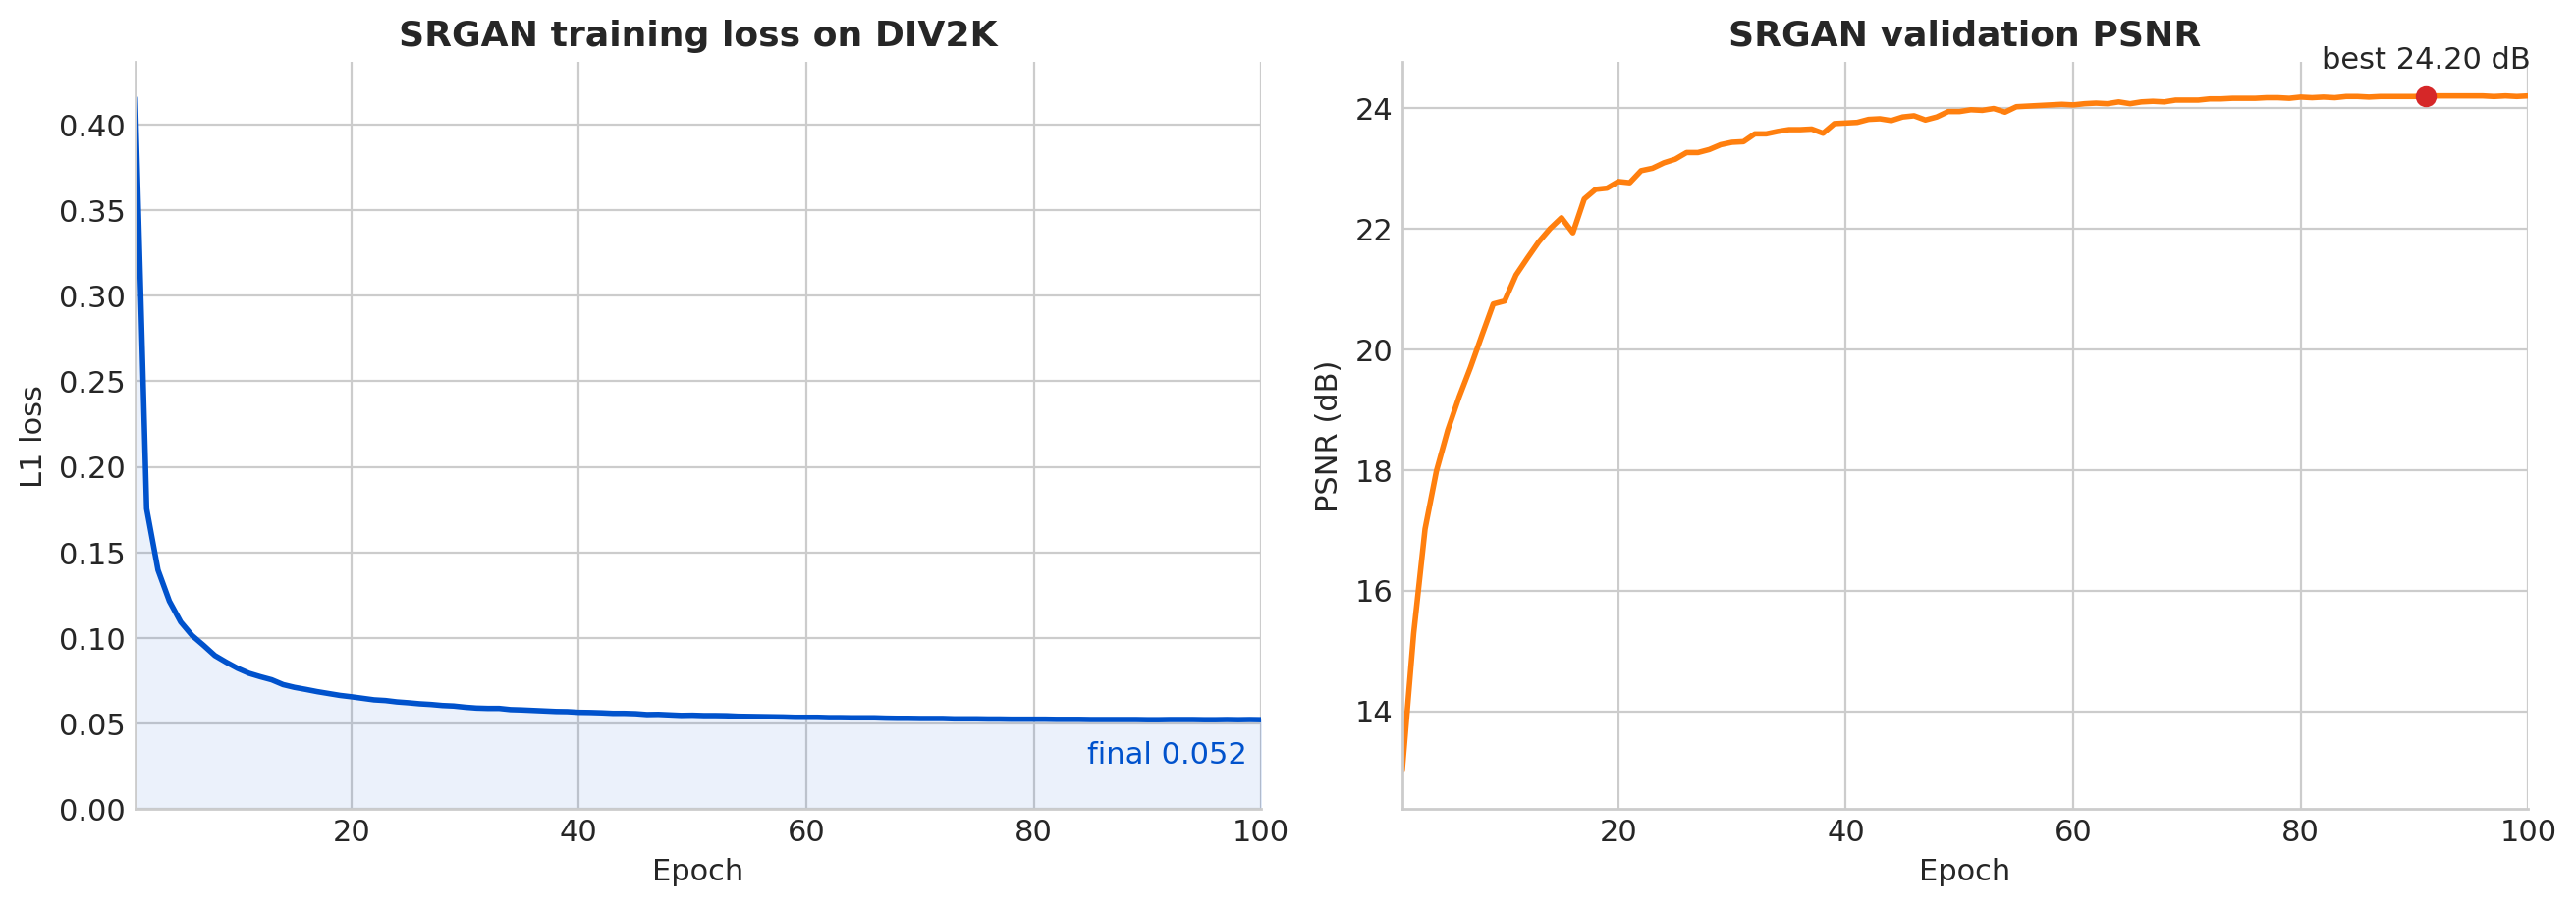

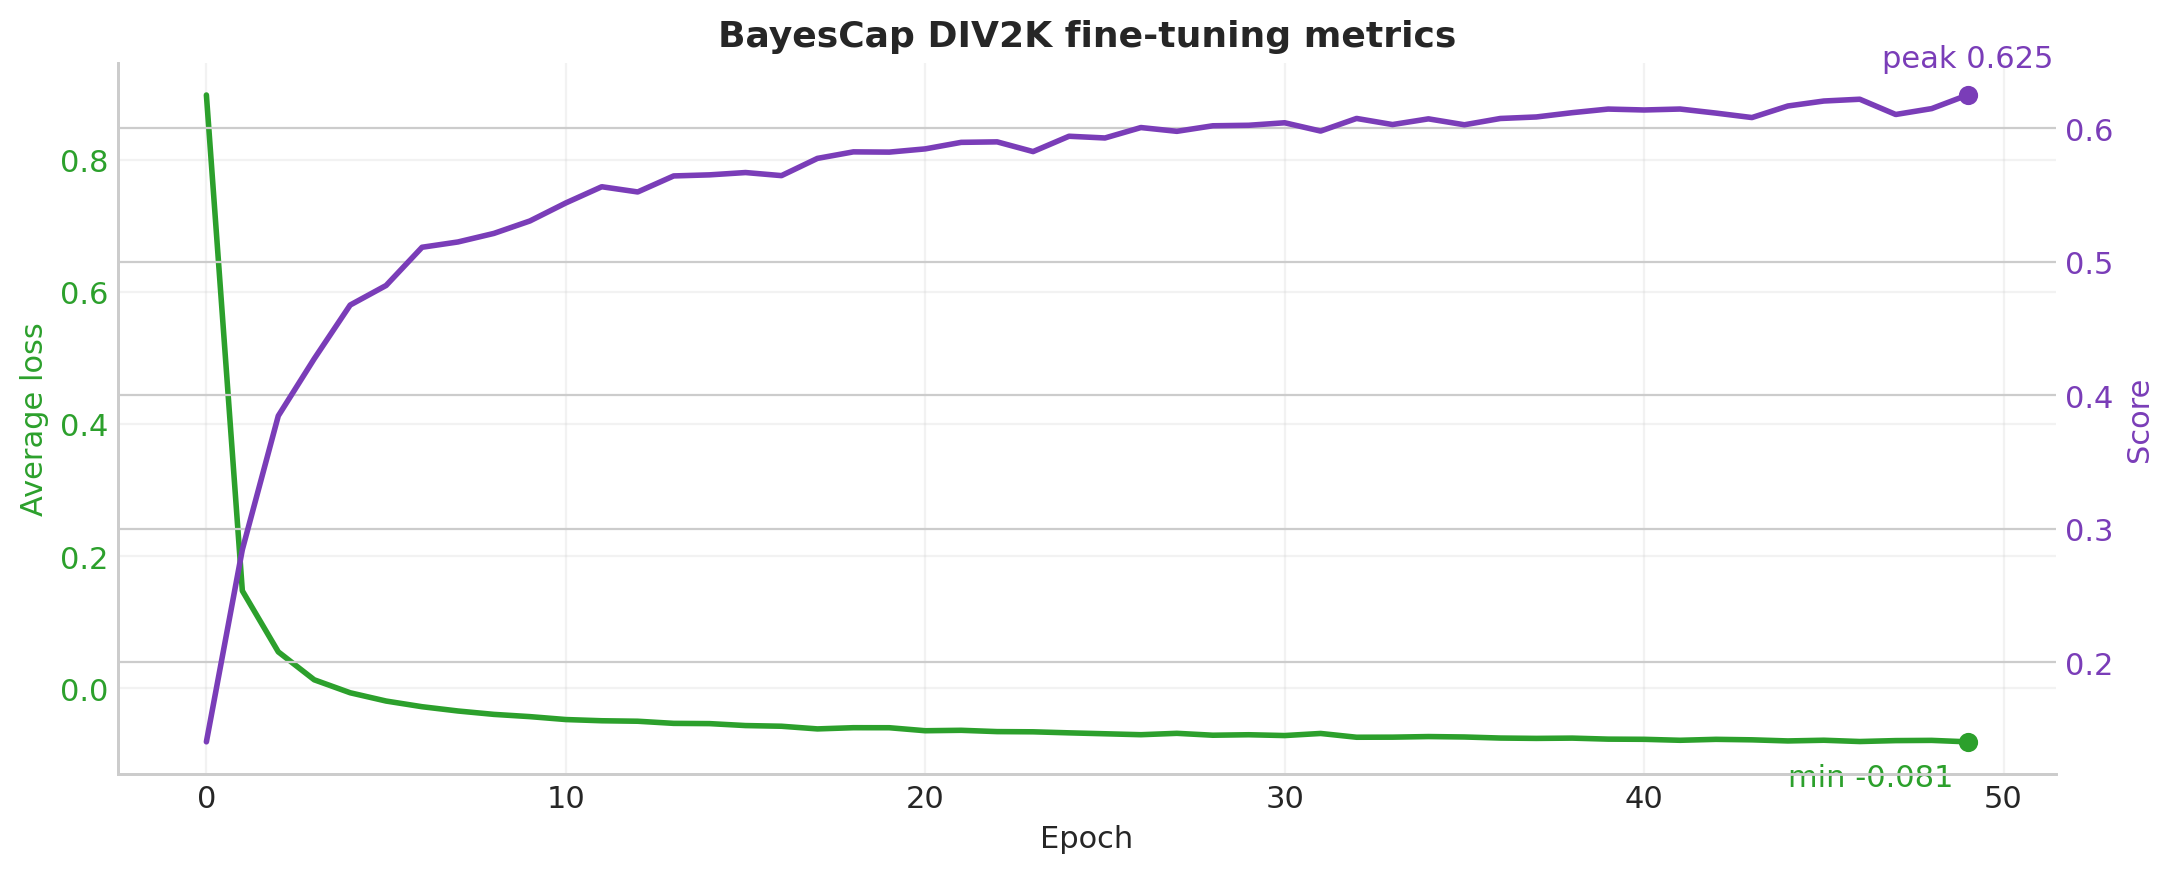

In [10]:
if srgan_df.empty or bayescap_df.empty:
    raise RuntimeError("Failed to parse one or both training logs; please verify the log paths and format.")

best_psnr_row = srgan_df.loc[srgan_df['val_psnr'].idxmax()]
best_score_row = bayescap_df.loc[bayescap_df['score'].idxmax()]
best_loss_row = bayescap_df.loc[bayescap_df['avg_loss'].idxmin()]

results_dir = project_root / 'results'
results_dir.mkdir(exist_ok=True)
srgan_fig_path = results_dir / 'srgan_div2k_training.png'
bayes_fig_path = results_dir / 'bayescap_div2k_finetuning.png'

plt.rcParams.update(
    {
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 11,
        'figure.titlesize': 15,
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)
plt.style.use('seaborn-v0_8-whitegrid')
accent_blue = '#0052cc'
accent_orange = '#ff7f0e'
accent_green = '#2ca02c'
accent_purple = '#7a3db8'

fig_srgan, srgan_axes = plt.subplots(1, 2, figsize=(13, 4.5), dpi=200, constrained_layout=True)
srgan_axes[0].plot(srgan_df['epoch'], srgan_df['train_loss'], color=accent_blue, linewidth=2)
srgan_axes[0].fill_between(srgan_df['epoch'], srgan_df['train_loss'], color=accent_blue, alpha=0.08)
srgan_axes[0].set_title('SRGAN training loss on DIV2K')
srgan_axes[0].set_xlabel('Epoch')
srgan_axes[0].set_ylabel('L1 loss')
srgan_axes[0].set_ylim(bottom=0)
srgan_axes[0].annotate(
    f"final {srgan_df['train_loss'].iloc[-1]:.3f}",
    (srgan_df['epoch'].iloc[-1], srgan_df['train_loss'].iloc[-1]),
    textcoords='offset points',
    xytext=(-5, -16),
    ha='right',
    color=accent_blue,
)
srgan_axes[0].margins(x=0)

srgan_axes[1].plot(srgan_df['epoch'], srgan_df['val_psnr'], color=accent_orange, linewidth=2)
srgan_axes[1].scatter(best_psnr_row['epoch'], best_psnr_row['val_psnr'], color='#d62728', s=45, zorder=5)
srgan_axes[1].annotate(
    f"best {best_psnr_row['val_psnr']:.2f} dB",
    (best_psnr_row['epoch'], best_psnr_row['val_psnr']),
    textcoords='offset points',
    xytext=(0, 10),
    ha='center',
)
srgan_axes[1].set_title('SRGAN validation PSNR')
srgan_axes[1].set_xlabel('Epoch')
srgan_axes[1].set_ylabel('PSNR (dB)')
srgan_axes[1].set_ylim(bottom=srgan_df['val_psnr'].min() * 0.95)
srgan_axes[1].margins(x=0)

fig_srgan.savefig(srgan_fig_path, bbox_inches='tight', dpi=300)

fig_bayes, bayes_ax = plt.subplots(figsize=(11, 4.5), dpi=200)
bayes_ax2 = bayes_ax.twinx()
bayes_ax.plot(bayescap_df['epoch'], bayescap_df['avg_loss'], color=accent_green, linewidth=2, label='Avg loss')
bayes_ax.scatter(best_loss_row['epoch'], best_loss_row['avg_loss'], color=accent_green, s=35)
bayes_ax.set_ylabel('Average loss', color=accent_green)
bayes_ax.tick_params(axis='y', labelcolor=accent_green)

bayes_ax2.plot(bayescap_df['epoch'], bayescap_df['score'], color=accent_purple, linewidth=2, label='Score')
bayes_ax2.scatter(best_score_row['epoch'], best_score_row['score'], color=accent_purple, s=35)
bayes_ax2.set_ylabel('Score', color=accent_purple)
bayes_ax2.tick_params(axis='y', labelcolor=accent_purple)

bayes_ax.set_xlabel('Epoch')
bayes_ax.set_title('BayesCap DIV2K fine-tuning metrics')
bayes_ax.annotate(
    f"min {best_loss_row['avg_loss']:.3f}",
    (best_loss_row['epoch'], best_loss_row['avg_loss']),
    textcoords='offset points',
    xytext=(-5, -16),
    ha='right',
    color=accent_green,
)
bayes_ax2.annotate(
    f"peak {best_score_row['score']:.3f}",
    (best_score_row['epoch'], best_score_row['score']),
    textcoords='offset points',
    xytext=(0, 10),
    ha='center',
    color=accent_purple,
)
bayes_ax.grid(alpha=0.25)
fig_bayes.tight_layout()
fig_bayes.savefig(bayes_fig_path, bbox_inches='tight', dpi=300)

print(f"Saved SRGAN figure to {srgan_fig_path}")
print(f"Saved BayesCap figure to {bayes_fig_path}")

summary_df = pd.DataFrame(
    {
        'Model': ['SRGAN', 'BayesCap'],
        'Metric': ['Best Val PSNR (dB)', 'Peak Score'],
        'Epoch': [int(best_psnr_row['epoch']), int(best_score_row['epoch'])],
        'Value': [round(best_psnr_row['val_psnr'], 2), round(best_score_row['score'], 3)],
    }
)
summary_df